In [5]:
#so empty
from ase.io import read
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

def gaussian(x, mu, sig):
    return 1/sig/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sig**2))

indices of pos_list[:,:,:] go over time, atoms, cart

Equation to implement is 

$G_{d}(r,t) = N^{-1} \sum_{i} \sum_{j \neq i} \langle \delta(r - |r_i(t) - r_j
(0)|) \rangle $



Implementation:

for each atom_${i}$ at t=t place it in atoms at t=0, remove the same atoms by index, then calculate all distance to neighbor atoms j within a cutoff using matscipy's neighbors_list. Perform convolution then average over atom i.

In [75]:
from matscipy.neighbours import neighbour_list
from tqdm import tqdm
from matscipy.neighbours import mic 

# def convolution(d)

def d_to_acf(r_t_it0_j0, r_cut = 5.0,grid_size=201):
    r_grid = np.linspace(0,r_cut, grid_size)
    acf_t = np.zeros([r_t_it0_j0.shape[0],grid_size])
    for t, r_it0_j0 in enumerate(r_t_it0_j0):
        mask1 = r_it0_j0<r_cut
        mask2 = r_it0_j0>0.
        for mu in r_it0_j0[np.logical_and(mask1, mask2)].ravel():
            acf_t[t] += 1/mu**2 * gaussian(r_grid, mu, sig=0.1)
    acf_t /= (r_t_it0_j0.shape[1])*(r_t_it0_j0.shape[1]-1)
    return r_grid, acf_t
        
def d_to_acf2(r_t0_t_it0_j0, r_cut = 5.0,grid_size=201):
    r_grid = np.linspace(0,r_cut, grid_size)
    acf_t = np.zeros([r_t0_t_it0_j0.shape[0],grid_size])
    for t, r_it0_j0 in enumerate(r_t0_t_it0_j0):
        mask1 = r_it0_j0<r_cut
        mask2 = r_it0_j0>0.
        for mu in r_it0_j0[np.logical_and(mask1, mask2)].ravel():
            acf_t[t] += 1/mu**2 * gaussian(r_grid, mu, sig=0.1)
    acf_t = acf_t.sum(axis=0)
    acf_t /= (r_t0_t_it0_j0.shape[1])*(r_t0_t_it0_j0.shape[1]-1)
    return r_grid, acf_t
        

def hv_acf_d_avg(traj):
    n_atoms = len(traj[0])
    n_time = len(traj)
    acf_t = []
    r_t_it0_j0 = np.zeros([n_time, n_atoms,n_atoms])
    for t_idx, atoms_t in enumerate(tqdm(traj)):
        #r_it0_j0 = np.zeros([n_atoms,n_atoms])
        for i in range(n_atoms):
            atoms_t0 = traj[0]
            dis_vec = np.vstack([
                atoms_t0.get_positions()[:i], 
                atoms_t.get_positions()[i], 
                atoms_t0.get_positions()[i+1:]]
                ) - atoms_t.get_positions()[i]
            r_t_it0_j0[t_idx, i] = np.linalg.norm(mic(dis_vec, atoms_t.cell),axis=1)
        #r_t_it0_j0.append(r_it0_j0)
        #acf.append(np.average(rdf_i, axis=0))
        #acf_t.append(d_to_acf2(r_t_it0_j0)[1]/r_t_it0_j0.shape[0])
    r, acf_t = d_to_acf(r_t_it0_j0)
    return r, acf_t

def hv_acf_d_time_average(traj):
    n_atoms = len(traj[0])
    n_time = len(traj)
    acf_t = []
    for t_idx, atoms_t in enumerate(tqdm(traj)):
        r_t0_it0_j0 = np.zeros([n_time-t_idx, n_atoms,n_atoms])
        #for t_idx, atoms_t in enumerate(tqdm(traj)):
        #print(len(traj[t0_idx:]))
        for t0_idx, atoms_t0 in enumerate(traj[t_idx:]):
            #r_it0_j0 = np.zeros([n_atoms,n_atoms])
            for i in range(n_atoms):
                #atoms_t0 = traj[0]
                dis_vec = np.vstack([
                    atoms_t0.get_positions()[:i], 
                    atoms_t.get_positions()[i], 
                    atoms_t0.get_positions()[i+1:]]
                    ) - atoms_t.get_positions()[i]
                r_t0_it0_j0[t0_idx, i] = np.linalg.norm(mic(dis_vec, atoms_t.cell),axis=1)
        acf_t.append(d_to_acf2(r_t0_it0_j0)[1]/r_t0_it0_j0.shape[0])
        #acf.append(np.average(rdf_i, axis=0))
    return d_to_acf2(r_t0_it0_j0)[0], acf_t

from ase.io import read
traj = read('./traj/md_seed_0_conc0.2500_800K.traj', ':')

In [76]:
# from ase.io import read
# traj = read('./traj/md_seed_0_conc0.5000_800K.traj', ':')

r, acf_t = hv_acf_d_avg(
    [atoms[[atom.index for atom in atoms if atom.symbol=='H']] for atoms in traj]
    )

100%|███████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 91.73it/s]


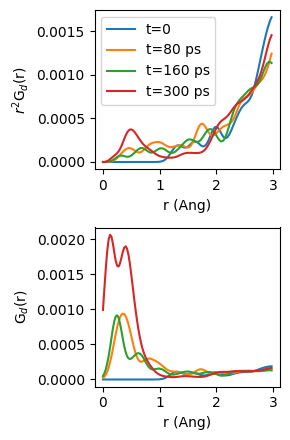

In [77]:
# r, acf_t = d_to_acf(r_t_it0_j0)
import matplotlib.pyplot as plt

# r = np.linspace(0, 3, 1000)

fig, ax = plt.subplots(2,1,figsize=[3,4.5])

x = r[r<3]
y = [y[r<3] for y in acf_t]

ax[0].plot(x, y[0]*x**2)
ax[0].plot(x, y[40]*x**2)
ax[0].plot(x, y[80]*x**2)
ax[0].plot(x, y[149]*x**2)
#ax[0].set_xlim([0,6])
#ax[0].set_ylim([0,0.5])
ax[0].set_ylabel(r'$r^{2}$G$_{d}$(r)')
ax[0].set_xlabel('r (Ang)')
ax[1].plot(x, y[0])
ax[1].plot(x, y[40])
ax[1].plot(x, y[80])
ax[1].plot(x, y[149])

# # inset Axes....
# x1, x2, y1, y2 = 2, 3, 0, 0.1  # subregion of the original image
# axins = ax[1].inset_axes(
#     [0.5, 0.5, 0.47, 0.47],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# #axins.plot(r,, extent=extent, origin="lower")
# axins.plot(r, acf[0])
# axins.plot(r, acf[40])
# axins.plot(r, acf[80])
# axins.plot(r, acf[149])

# ax[1].indicate_inset_zoom(axins, edgecolor="black")

#ax[1].set_xlim([0,6])
ax[1].set_ylabel(r'G$_{d}$(r)')
ax[1].set_xlabel('r (Ang)')
ax[0].legend(['t=0', 't=80 ps', 't=160 ps', 't=300 ps'])
fig.tight_layout()
fig.savefig('acf.png', dpi=300)

In [78]:
r, acf_t = hv_acf_d_time_average(
    [atoms[[atom.index for atom in atoms if atom.symbol=='H']] for atoms in traj]
    )

100%|███████████████████████████████████████████████████████████████████████████| 150/150 [02:40<00:00,  1.07s/it]


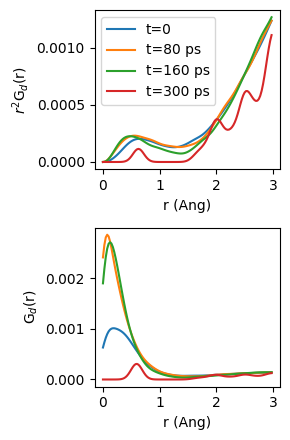

In [79]:
import matplotlib.pyplot as plt

# r = np.linspace(0, 3, 1000)

fig, ax = plt.subplots(2,1,figsize=[3,4.5])

x = r[r<3]
y = [y[r<3] for y in acf_t]

ax[0].plot(x, y[0]*x**2)
ax[0].plot(x, y[40]*x**2)
ax[0].plot(x, y[80]*x**2)
ax[0].plot(x, y[149]*x**2)
#ax[0].set_xlim([0,6])
#ax[0].set_ylim([0,0.5])
ax[0].set_ylabel(r'$r^{2}$G$_{d}$(r)')
ax[0].set_xlabel('r (Ang)')
ax[1].plot(x, y[0])
ax[1].plot(x, y[40])
ax[1].plot(x, y[80])
ax[1].plot(x, y[149])

# # inset Axes....
# x1, x2, y1, y2 = 2, 3, 0, 0.1  # subregion of the original image
# axins = ax[1].inset_axes(
#     [0.5, 0.5, 0.47, 0.47],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# #axins.plot(r,, extent=extent, origin="lower")
# axins.plot(r, acf[0])
# axins.plot(r, acf[40])
# axins.plot(r, acf[80])
# axins.plot(r, acf[149])

# ax[1].indicate_inset_zoom(axins, edgecolor="black")

#ax[1].set_xlim([0,6])
ax[1].set_ylabel(r'G$_{d}$(r)')
ax[1].set_xlabel('r (Ang)')
ax[0].legend(['t=0', 't=80 ps', 't=160 ps', 't=300 ps'])
fig.tight_layout()
fig.savefig('acf_t0.png', dpi=300)

In [11]:
r_t_it0_j0[0].shape

(768, 768)

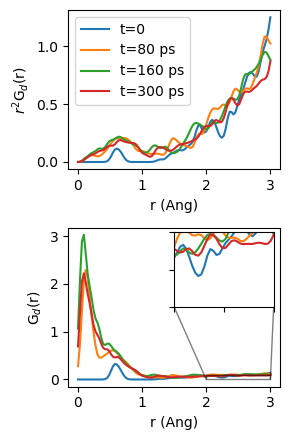

In [286]:
import matplotlib.pyplot as plt

# r = np.linspace(0, 3, 1000)

fig, ax = plt.subplots(2,1,figsize=[3,4.5])

ax[0].plot(r, acf[0]*r**2)
ax[0].plot(r, acf[40]*r**2)
ax[0].plot(r, acf[80]*r**2)
ax[0].plot(r, acf[149]*r**2)
#ax[0].set_xlim([0,6])
#ax[0].set_ylim([0,0.5])
ax[0].set_ylabel(r'$r^{2}$G$_{d}$(r)')
ax[0].set_xlabel('r (Ang)')
ax[1].plot(r, acf[0])
ax[1].plot(r, acf[40])
ax[1].plot(r, acf[80])
ax[1].plot(r, acf[149])

# inset Axes....
x1, x2, y1, y2 = 2, 3, 0, 0.1  # subregion of the original image
axins = ax[1].inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
#axins.plot(r,, extent=extent, origin="lower")
axins.plot(r, acf[0])
axins.plot(r, acf[40])
axins.plot(r, acf[80])
axins.plot(r, acf[149])

ax[1].indicate_inset_zoom(axins, edgecolor="black")

#ax[1].set_xlim([0,6])
ax[1].set_ylabel(r'G$_{d}$(r)')
ax[1].set_xlabel('r (Ang)')
ax[0].legend(['t=0', 't=80 ps', 't=160 ps', 't=300 ps'])
fig.tight_layout()
fig.savefig('acf.png', dpi=300)
#ax[1].set_ylim([0,0.3])




In [270]:
traj2 = [atoms[[atom.index for atom in atoms if atom.symbol=='H']] for atoms in traj]
r = np.linspace(0, 3, 100)
atoms_t = traj2[80]
rdf_i=[]
for i in range(len(atoms_t)):
    atoms_0 = traj2[0]
    #atoms_0.pop(i)
    atoms_0_pos = np.vstack([atoms_0.get_positions()[:i], atoms_0.get_positions()[i+1:]])
    dis_vec = atoms_t.get_positions()[i] - atoms_0_pos
    #r_it_j0 = np.linalg.norm(mic(dis_vec, atoms_t.cell),axis=1)
    r_it_j0 = np.linalg.norm(dis_vec,axis=1)
    #i, j, d = neighbour_list('ijd', new_atoms, cutoff=r_cut)
    #r_it_j0 = np.array(d)
    rdf_s = np.sum([1/dis**2 * gaussian(r,mu =dis, sig=0.15) for dis in r_it_j0], axis=0)
    rdf_i.append(rdf_s)
acf_40 = np.average(rdf_i, axis=0)

In [258]:
np.sort(np.linalg.norm(dis_vec,axis=1))

array([ 6.90019482,  6.95947078,  7.10315431,  7.15651825,  7.31419717,
        7.35475143,  7.60965114,  7.88123789,  7.91940222,  8.87025856,
        9.35905036,  9.53333581,  9.74597436, 10.60581357, 10.67228885,
       10.74279236, 10.76858089, 10.86199799, 11.15490941, 11.27712516,
       11.33257944, 11.34332788, 11.3758892 , 11.40023386, 11.44043883,
       11.49957768, 11.50101719, 11.5380016 , 11.90952935, 11.94872783,
       12.09188953, 12.16630971, 12.86904117, 12.8693558 , 12.91925492,
       13.12513272, 13.22781853, 13.2624887 , 13.66146298, 13.96397969,
       14.05078143, 14.24174123, 14.58075072, 14.64809187, 15.12487262,
       15.22907499, 15.28823311, 15.67631322, 15.75680129, 15.85077768,
       15.99666436, 16.04219222, 16.1412508 , 16.21808062, 16.37039932,
       16.40378727, 16.85811457, 17.01990382, 17.1802088 , 17.21525523,
       17.22055713, 17.41001043, 17.42370389, 17.43464236, 17.45496053,
       17.47187117, 17.55864553, 17.63351503, 17.66593573, 17.69

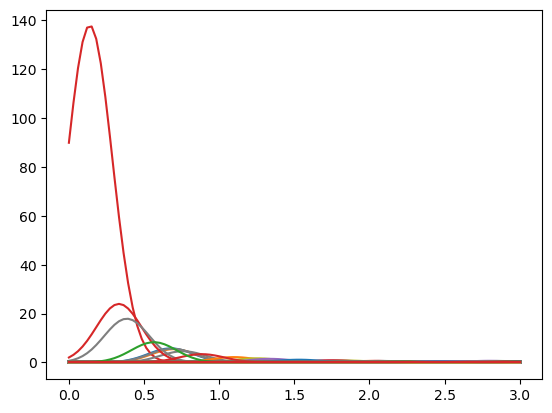

In [271]:
for rdf in rdf_i[:]:
    plt.plot(r, rdf)

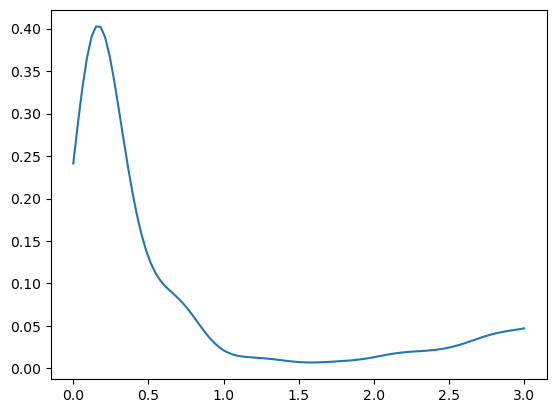

In [272]:
plt.plot(r, acf_40)

In [263]:
i, j, d = neighbour_list('ijd', atoms_t, cutoff=2.0)

In [264]:
sorted(d)

[1.7236401383750286, 1.7236401383750286]

In [150]:
acf[40]

array([0.01467385, 0.01541237, 0.01616999, 0.01694611, 0.01774005,
       0.01855111, 0.01937848, 0.02022135, 0.02107881, 0.02194995,
       0.02283379, 0.02372931, 0.02463547, 0.02555117, 0.02647533,
       0.0274068 , 0.02834444, 0.02928709, 0.03023357, 0.03118273,
       0.03213337, 0.03308433, 0.03403443, 0.03498251, 0.03592744,
       0.03686807, 0.03780329, 0.03873201, 0.03965315, 0.04056566,
       0.04146851, 0.04236069, 0.04324123, 0.04410917, 0.04496357,
       0.04580355, 0.04662821, 0.04743671, 0.04822822, 0.04900193,
       0.04975706, 0.05049286, 0.05120859, 0.05190353, 0.052577  ,
       0.05322833, 0.05385689, 0.05446204, 0.0550432 , 0.05559979,
       0.05613127, 0.05663712, 0.05711686, 0.05757003, 0.0579962 ,
       0.05839499, 0.05876603, 0.05910901, 0.05942366, 0.05970974,
       0.05996707, 0.0601955 , 0.06039493, 0.06056533, 0.0607067 ,
       0.06081911, 0.06090265, 0.06095751, 0.06098391, 0.06098212,
       0.06095246, 0.06089533, 0.06081115, 0.06070042, 0.06056

In [142]:
atoms_0 = traj[0]
i=400
#atoms_0.pop(i)
atoms_0_pos = np.vstack([atoms_0.get_positions()[:i], atoms_0.get_positions()[i+1:]])
dis_vec = atoms_t.get_positions()[i] - atoms_0_pos
r_it_j0 = np.linalg.norm(mic(dis_vec, atoms_t.cell),axis=1)
rdf_s = np.sum([gaussian(r,mu =dis, sig=0.15) for dis in r_it_j0], axis=0)

/var/folders/fk/d0qs65yx5sn7pph7l_w3jml80000gs/T/ipykernel_43628/4023159032.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(r,rdf_s/r**2)


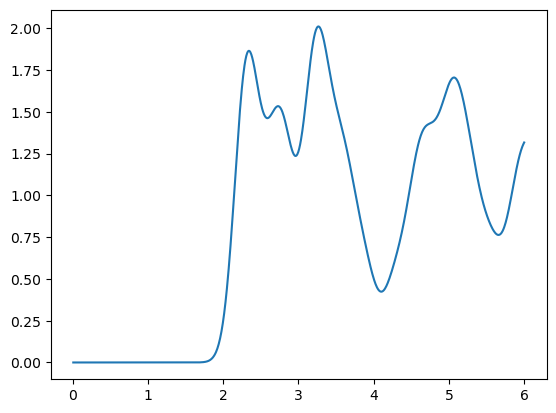

In [143]:
# plt.plot(r, gaussian(r,mu =r_it_j0[0], sig=0.15))
plt.plot(r,rdf_s/r**2)

In [144]:
rdf_s

array([1.44401272e-50, 2.65818021e-50, 4.88541688e-50, 8.96442925e-50,
       1.64228100e-49, 3.00383521e-49, 5.48540312e-49, 1.00010318e-48,
       1.82047567e-48, 3.30848193e-48, 6.00311235e-48, 1.08749681e-47,
       1.96690477e-47, 3.55175088e-47, 6.40332406e-47, 1.15258321e-46,
       2.07129961e-46, 3.71635663e-46, 6.65726236e-46, 1.19063266e-45,
       2.12600236e-45, 3.79012494e-45, 6.74601257e-45, 1.19879411e-44,
       2.12689425e-44, 3.76748066e-44, 6.66284959e-44, 1.17644826e-43,
       2.07390805e-43, 3.65014413e-43, 6.41408009e-43, 1.12528517e-42,
       1.97103650e-42, 3.44691515e-42, 6.01825213e-42, 1.04909308e-41,
       1.82583501e-41, 3.17258235e-41, 5.50386969e-41, 9.53294859e-41,
       1.64850486e-40, 2.84614542e-40, 4.90600307e-40, 8.44310957e-40,
       1.45071104e-39, 2.48864696e-39, 4.26235436e-39, 7.28852595e-39,
       1.24432477e-38, 2.12095613e-38, 3.60938759e-38, 6.13252401e-38,
       1.04027676e-37, 1.76182368e-37, 2.97906444e-37, 5.02922731e-37,
      

In [138]:
rdf_s[0]

1.444012715982703e-50

In [141]:
1/r**2

/var/folders/fk/d0qs65yx5sn7pph7l_w3jml80000gs/T/ipykernel_43628/3958539234.py:1: RuntimeWarning: divide by zero encountered in divide
  1/r**2


array([           inf, 2.77222500e+04, 6.93056250e+03, 3.08025000e+03,
       1.73264062e+03, 1.10889000e+03, 7.70062500e+02, 5.65760204e+02,
       4.33160156e+02, 3.42250000e+02, 2.77222500e+02, 2.29109504e+02,
       1.92515625e+02, 1.64036982e+02, 1.41440051e+02, 1.23210000e+02,
       1.08290039e+02, 9.59247405e+01, 8.55625000e+01, 7.67929363e+01,
       6.93056250e+01, 6.28622449e+01, 5.72773760e+01, 5.24050095e+01,
       4.81289062e+01, 4.43556000e+01, 4.10092456e+01, 3.80277778e+01,
       3.53600128e+01, 3.29634364e+01, 3.08025000e+01, 2.88472945e+01,
       2.70725098e+01, 2.54566116e+01, 2.39811851e+01, 2.26304082e+01,
       2.13906250e+01, 2.02500000e+01, 1.91982341e+01, 1.82263314e+01,
       1.73264062e+01, 1.64915229e+01, 1.57155612e+01, 1.49931044e+01,
       1.43193440e+01, 1.36900000e+01, 1.31012524e+01, 1.25496831e+01,
       1.20322266e+01, 1.15461266e+01, 1.10889000e+01, 1.06583045e+01,
       1.02523114e+01, 9.86908152e+00, 9.50694444e+00, 9.16438017e+00,
      